In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [3]:
#{"DX": [], "DY": [], "DZ": [], "H": [], "log_f": [], "RP": []})
DATA = pd.read_csv("../csv/data.csv")
DATA.pop("Unnamed: 0")

ROW_NUM = len(DATA.index)
print(ROW_NUM)
TRAINING_NUM = int(ROW_NUM / 10 * 7)
VALIDATION_NUM = int(ROW_NUM / 20 * 3 )

TRAINING_DATA = DATA.iloc[ :TRAINING_NUM,:]
VALIDATION_DATA = DATA.iloc[TRAINING_NUM:TRAINING_NUM+VALIDATION_NUM,:]
TEST_DATA = DATA.iloc[TRAINING_NUM+VALIDATION_NUM:,:]
TRAINING_VAL = pd.DataFrame(TRAINING_DATA.pop('RP'))
VALIDATION_VAL = pd.DataFrame(VALIDATION_DATA.pop('RP'))
TEST_VAL = pd.DataFrame(TEST_DATA.pop('RP'))

DATA.pop('RP')


452864


0        -117.750391
1         -69.327201
2        -106.181961
3        -112.981354
4        -128.770041
             ...    
452859   -135.552306
452860   -155.180482
452861   -105.433740
452862   -151.030553
452863   -179.902905
Name: RP, Length: 452864, dtype: float64

In [4]:
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
min_max_scaler.fit(DATA)
joblib.dump(min_max_scaler, "MLP.scaler.gz") 

TRAINING_DATA = min_max_scaler.transform(TRAINING_DATA)
TRAINING_DATA = pd.DataFrame(TRAINING_DATA)
VALIDATION_DATA = min_max_scaler.transform(VALIDATION_DATA)
VALIDATION_DATA = pd.DataFrame(VALIDATION_DATA)
TEST_DATA = min_max_scaler.transform(TEST_DATA)
TEST_DATA = pd.DataFrame(TEST_DATA)

In [27]:
model = keras.models.Sequential([
    keras.layers.Dense(160,activation="tanh", input_dim=5),
    keras.layers.Dense(1, activation="linear")
])

model.compile(loss="mean_squared_error", optimizer='adam')

epochs=2000
batch=100


model_name = f"{model.layers[0].input_shape[1]}"
for layer in model.layers:
    model_name+=f"-{layer.output_shape[1]}"
model_name += f"_e:{epochs}_b:{batch}"
print(model_name)

5-160-1_e:2000_b:100


Epoch 1/2000
3171/3171 [==============================] - 3s 765us/step - loss: 1728.3977 - val_loss: 92.8749
Epoch 2/2000
3171/3171 [==============================] - 2s 727us/step - loss: 56.1152 - val_loss: 38.8551
Epoch 3/2000
3171/3171 [==============================] - 2s 741us/step - loss: 34.0939 - val_loss: 31.3494
Epoch 4/2000
3171/3171 [==============================] - 2s 723us/step - loss: 25.6795 - val_loss: 19.0758
Epoch 5/2000
3171/3171 [==============================] - 2s 724us/step - loss: 15.6962 - val_loss: 13.7281
Epoch 6/2000
3171/3171 [==============================] - 2s 750us/step - loss: 12.6725 - val_loss: 11.9421
Epoch 7/2000
3171/3171 [==============================] - 2s 682us/step - loss: 11.3446 - val_loss: 10.9460
Epoch 8/2000
3171/3171 [==============================] - 2s 663us/step - loss: 10.6103 - val_loss: 10.4210
Epoch 9/2000
3171/3171 [==============================] - 2s 665us/step - loss: 10.1155 - val_loss: 10.1515
Epoch 10/2000
3171/3171 [=

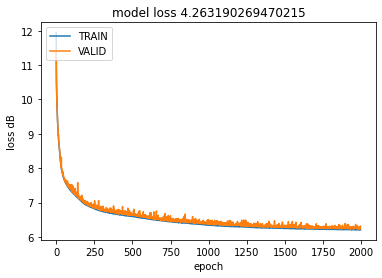

In [11]:
history = model.fit(TRAINING_DATA, TRAINING_VAL, epochs=epochs, batch_size=batch, validation_data=(VALIDATION_DATA, VALIDATION_VAL))
model.save(f"MODELS/{model_name}.h5")

from math import log10

scores = model.evaluate(TEST_DATA, TEST_VAL, batch_size=20)
plt.plot([10*log10(loss) for loss in history.history['loss'][4:]])
plt.plot([10*log10(loss) for loss in history.history['val_loss'][4:]])
plt.title(f'model loss {scores}')
plt.ylabel('loss dB')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VALID'], loc='upper left')
plt.savefig(f"TRAINING_PROCESS/{model_name}.png")
plt.show()


In [16]:
TEST_DATA = TEST_DATA.iloc[:30,:]
PREDICTIONS = pd.DataFrame(model.predict(TEST_DATA))
PREDICTIONS.columns=["PREDICITONS"]

TEST_VAL = TEST_VAL.iloc[:30,:]
TEST_VAL.columns=["TEST_VAL"]
TEST_VAL = TEST_VAL.reset_index(drop=True)

result=pd.concat([PREDICTIONS, TEST_VAL], axis=1)
result["ERROR"] = result["PREDICITONS"] - result["TEST_VAL"]
result.to_csv("MLP.csv")
